In [71]:
import collections
import glob
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import random

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from utils_parallel_syn_gradient import *
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})/

In [72]:
experi = {}
allN = set()
allM = set()
for N in [200]:
    path = glob.glob("./N_" + str(N) + "_png/*seed_[0-9].png") + glob.glob(
        "./N_" + str(N) + "_png/*seed_[0-9]_true.png"
    )

    for p_ in path:
        params = p_.split("/")[-1].replace(".png", "").split("_")

        N_, M_, P_, seed_ = (
            int(params[1]),
            int(params[3]),
            int(params[5]),
            int(params[7]),
        )
        if (N_, M_) not in experi:
            experi[(N_, M_)] = {}
        if P_ not in experi[(N_, M_)]:
            experi[(N_, M_)][P_] = np.ones((20,), dtype=int) * np.nan

        if experi[(N_, M_)][P_][seed_] > 0:
            continue
        else:
            experi[(N_, M_)][P_][seed_] = int(params[-1] == "true")

        if N_ not in allN:
            allN.add(N_)
        if M_ not in allM:
            allM.add(M_)

    for N_, M_ in experi:
        for P_ in experi[(N_, M_)]:
            experi[(N_, M_)][P_] = experi[(N_, M_)][P_][~np.isnan(experi[(N_, M_)][P_])]
        experi[(N_, M_)] = collections.OrderedDict(sorted(experi[(N_, M_)].items()))

arrayN = np.array(sorted(list(allN)))
arrayM = np.array(sorted(list(allM)))
countTrialDict = {}
for N in arrayN:
    for M in arrayM:
        if (N, M) in experi:
            countTrial = []
            for k in experi[(N, M)]:
                countTrial.append(
                    (
                        k,
                        k / N,
                        len(experi[(N, M)][k]),
                        sum(experi[(N, M)][k]) / len(experi[(N, M)][k]),
                    )
                )
            countTrialDict[(N, M)] = countTrial
        else:
            countTrialDict[(N, M)] = []

for N, M in countTrialDict:
    # if M != 10:
    #     continue
    print("N, M:", N, M, " P, alpha, count, rate: ")
    print(countTrialDict[(N, M)])
    print("----")

N, M: 200 5  P, alpha, count, rate: 
[(1800, 9.0, 9, 1.0), (2000, 10.0, 10, 1.0), (2200, 11.0, 10, 0.0)]
----


In [73]:
countTrialDict

{(200, 5): [(1800, 9.0, 9, 1.0), (2000, 10.0, 10, 1.0), (2200, 11.0, 10, 0.0)]}

In [74]:
# import csv
# filename = 'result.csv'
# experi_old = {}
# with open(filename, newline='') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',' )
#     for j,row in enumerate(reader):
#         print(', '.join(row))
#         if j > 0:
#             if (int(row[0]), int(row[1])) not in experi_old:
#                 experi_old[(int(row[0]), int(row[1]))] = \
#                     {int(row[2]) : [int(row[i]) for i in range(5,len(row)) if row[i]!='']}
#             else:
#                 experi_old[(int(row[0]), int(row[1]))][int(row[2])] = \
#                     [int(row[i]) for i in range(5,len(row)) if row[i]!='']
# for (N_, M_) in experi_old:
#     experi_old[(N_, M_)] = collections.OrderedDict(sorted(experi_old[(N_, M_)].items()))

In [75]:
# experi_old

In [76]:
# for (N, M) in experi_old:
#     if (N, M) not in experi:
#         experi[(N, M)] = experi_old[(N, M)]
# allM.add(5)

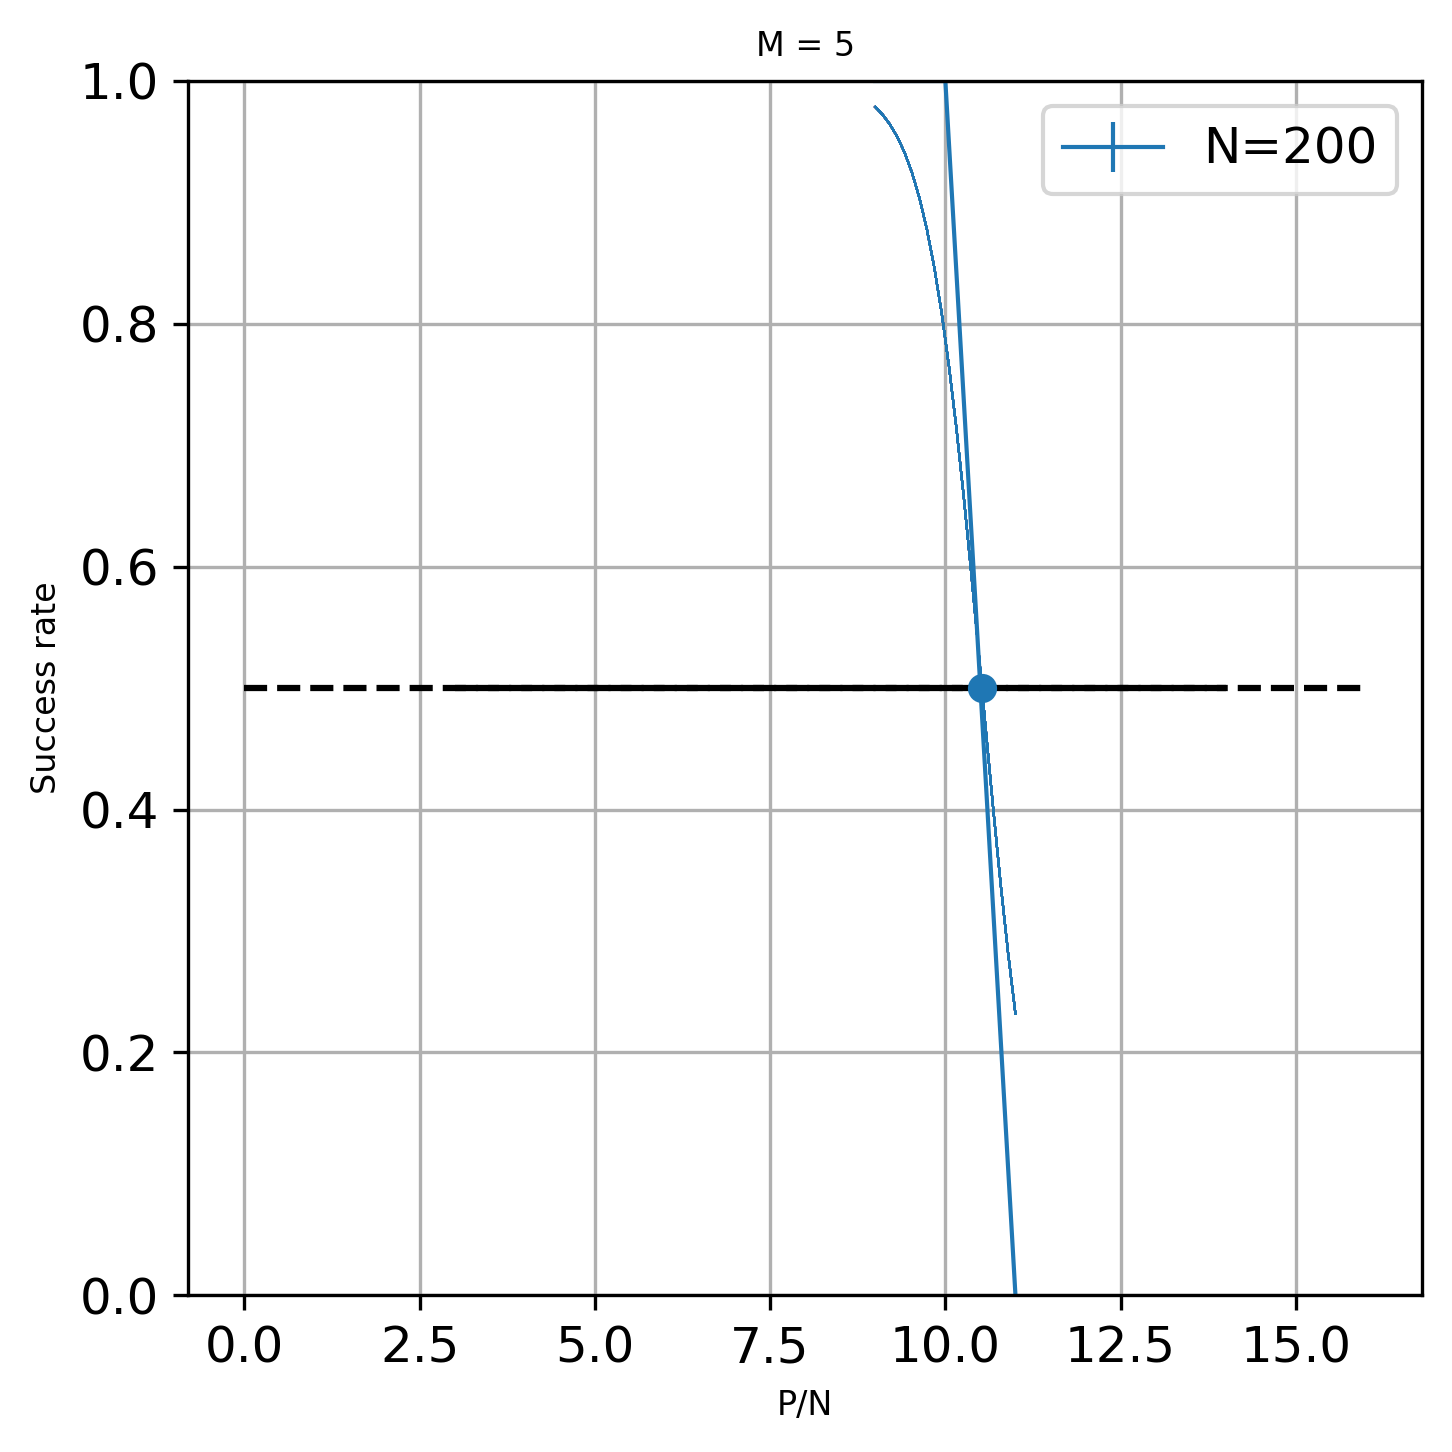

In [77]:
plt.figure(figsize=(5, 5), dpi=300)
plt.plot([3, 14], [0.5, 0.5], "k--")
c = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
]


arrayN = np.array(sorted(list(allN)))
arrayM = np.array(sorted(list(allM)))
capacity = {}
for count, (N, M) in enumerate(experi):
    if M not in [5]:
        continue
    if M not in capacity:
        capacity[M] = []

    sample = 100
    psedoC = []
    for i in range(sample):
        psedoX = []
        psedoY = []

        for P in experi[(N, M)]:
            psedoX += [P / N] * len(experi[(N, M)][P])
            psedoY += random.choices(experi[(N, M)][P], k=len(experi[(N, M)][P]))
        if min(psedoY) == max(psedoY):
            continue
        clf = LogisticRegression().fit(
            np.array(psedoX).reshape(-1, 1), np.array(psedoY)
        )
        newX = np.linspace(
            min(experi[(N, M)].keys()) / N, max(experi[(N, M)].keys()) / N, 20
        )
        if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
            continue
        psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

        probs = clf.predict_proba(newX.reshape(-1, 1))

        plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
        plt.plot(
            newX,
            probs[:, 1],
            alpha=0.15,
            linewidth=0.5,
            color=c[np.where(arrayN == N)[0][0]],
        )

    capacity[M].append(
        [N, M, np.nanmean(np.array(psedoC)), np.nanstd(np.array(psedoC))]
    )

    plt.subplot(arrayM.size, 1, np.where(arrayM == M)[0][0] + 1)
    plt.errorbar(
        np.array(list(experi[(N, M)].keys())) / N,
        [np.mean(np.array(experi[(N, M)][P])) for P in experi[(N, M)]],
        yerr=[
            np.std(np.array(experi[(N, M)][P])) / np.sqrt(len(experi[(N, M)][P]))
            for P in experi[(N, M)]
        ],
        label="N=" + str(N),
        linewidth=1,
        color=c[np.where(arrayN == N)[0][0]],
    )

    plt.errorbar(
        [np.array(psedoC).mean()],
        [0.5],
        xerr=np.array(psedoC).std(),
        fmt="o",
        linewidth=2,
        capsize=2,
        color=c[np.where(arrayN == N)[0][0]],
    )
for i in range(arrayM.size):
    plt.subplot(arrayM.size, 1, i + 1)
    plt.title("M = " + str(arrayM[i]), fontsize=8)
    plt.legend()
    # plt.xlim([0, 16])
    plt.ylim([0, 1])
    plt.plot([0, 16], [0.5, 0.5], "k--")
    plt.grid()
    plt.xlabel("P/N", fontsize=8)
    plt.ylabel("Success rate", fontsize=8)
for M in capacity:
    capacity[M] = np.array(capacity[M])
capacity = collections.OrderedDict(sorted(capacity.items()))

plt.tight_layout()

# plt.savefig("success_rate.pdf")
plt.show()

In [78]:
capacity

OrderedDict([(5,
              array([[200.        ,   5.        ,  10.52227675,   0.        ]]))])

# read two-step algorithm's result

In [79]:
experi2 = {}
path = glob.glob("./monsyn4/*[0-9].txt")
for p in path:
    p_ = p.replace("N", "_")
    p_ = p_.replace("P", "_")
    p_ = p_.replace("trial", "_")
    p_ = p_.split("_")
    N, P, seed = int(p_[1]), int(p_[2]), int(p_[3][0])

    if N not in experi2:
        experi2[N] = {}
    if P not in experi2[N]:
        experi2[N][P] = np.ones((20,), dtype=int) * np.nan
    try:
        with open(p, "r") as f:
            reader = f.read()
            experi2[N][P][seed] = int(reader.split(",")[3]) == 0
    except:
        continue

In [80]:
# experi2 = {}
# path = glob.glob('./monsyn4/*[0-9]_lmbdsmall.txt')
# for p in path:
#     p_ = p.replace('N','_')
#     p_ = p_.replace('P','_')
#     p_ = p_.replace('trial','_')
#     p_ = p_.split('_')
#     N, P, seed = int(p_[1]), int(p_[2]), int(p_[3][0])

#     if N not in experi2:
#         experi2[N] = {}
#     if P not in experi2[N]:
#         experi2[N][P] = np.ones((20, ), dtype = int) * np.nan
#     try:
#         with open(p, 'r') as f:
#             reader = f.read()

#             experi2[N][P][seed] = (int(reader.split(',')[3]) == 0)
#     except:
#         continue

In [81]:
for N in experi2:
    experi2[N] = collections.OrderedDict(sorted(experi2[(N)].items()))
    for P in experi2[N]:
        experi2[N][P] = experi2[N][P][~np.isnan(experi2[N][P])]

In [82]:
experi2 = collections.OrderedDict(sorted(experi2.items()))

In [83]:
experi2

OrderedDict()

In [84]:
# experi2[2000] = collections.OrderedDict([(32000, np.array([ 1., 1., 1., 1., 1.])),
#              (33000, np.array([1., 1., 1., 1., 1., 1.])),
#              (34000, np.array([0.])),
#              (35000, np.array([0., 0., 0., 0., 0., 0.])),
#              (38000, np.array([0., 0., 0., 0., 0.]))])

In [85]:
effM = {}  # effective steps for two-step algorithms
for N in experi2:
    if N == 2000 or N == 5000:
        continue
    if N not in effM:
        effM[N] = []
    for P in experi2[N]:
        seeds = np.where(experi2[N][P] == 1.0)[0]
        #         print(seeds)
        if seeds.size == 0:
            continue
        actv = []
        for seed in seeds:
            with open(
                "./monsyn4/N"
                + str(N)
                + "P"
                + str(P)
                + "trial"
                + str(seed)
                + "func.txt",
                "r",
            ) as f:
                line = f.readline()
                while line:
                    line = line.replace(" \n", "")
                    actv.append([float(a) for a in line.split(" ")])
                    line = f.readline()

        actv = np.array(actv)
        step = (np.diff(actv, axis=1) > 0.01).sum(axis=1)

        effM[N].append(step)

        print([N])

In [86]:
effM2 = []
for N in effM:
    if N == 5000:
        continue
    effM2.append(
        [np.array(np.hstack(effM[N])).mean(), np.array(np.hstack(effM[N])).std()]
    )

In [87]:
effM


{}

In [88]:
plt.figure(figsize=(4.5, 4.0))
plt.errorbar(effM.keys(), np.array(effM2)[:, 0], yerr=np.array(effM2)[:, 1], fmt="o")

plt.xscale("log")
plt.xlabel("N")
plt.title("effective number of parallel synapses")
plt.savefig("effectms.pdf")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 450x400 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


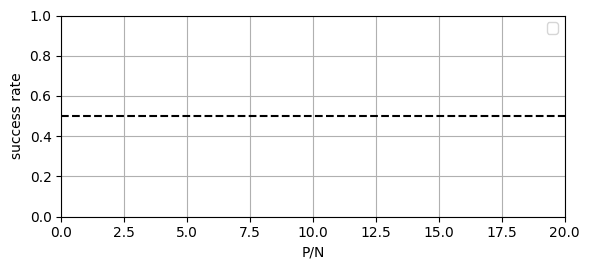

In [ ]:
plt.figure(figsize=(6, 2.8))

c = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:olive",
    "tab:cyan",
]

arrayN = np.array([10, 20, 50, 100, 500, 800, 1000, 2000, 5000])
capacityms = []
for count, N in enumerate(experi2):
    sample = 100
    psedoC = []
    for i in range(sample):
        psedoX = []
        psedoY = []

        for P in experi2[N]:
            psedoX += [P / N] * len(experi2[N][P])
            psedoY += random.choices(experi2[N][P], k=len(experi2[N][P]))
        if min(psedoY) == max(psedoY):
            continue
        clf = LogisticRegression().fit(
            np.array(psedoX).reshape(-1, 1), np.array(psedoY)
        )
        newX = np.linspace(min(experi2[N].keys()) / N, max(experi2[N].keys()) / N, 20)
        if np.abs(-clf.intercept_[0] / clf.coef_[0][0]) > 20:
            continue
        psedoC.append(-clf.intercept_[0] / clf.coef_[0][0])

        probs = clf.predict_proba(newX.reshape(-1, 1))

        plt.plot(
            newX,
            probs[:, 1],
            alpha=0.15,
            linewidth=0.5,
            color=c[np.where(arrayN == N)[0][0]],
        )

    capacityms.append([N, np.array(psedoC).mean(), np.array(psedoC).std()])

    plt.errorbar(
        np.array(list(experi2[N].keys())) / N,
        [np.mean(np.array(experi2[N][P])) for P in experi2[N]],
        yerr=[
            np.std(np.array(experi2[N][P])) / np.sqrt(len(experi2[N][P]))
            for P in experi2[N]
        ],
        label="N=" + str(N),
        linewidth=2,
        color=c[np.where(arrayN == N)[0][0]],
    )

    plt.errorbar(
        [np.array(psedoC).mean()],
        [0.5],
        xerr=np.array(psedoC).std(),
        fmt="o",
        linewidth=5,
        capsize=5,
        color=c[np.where(arrayN == N)[0][0]],
    )

capacityms = np.array(capacityms)
plt.legend()
plt.xlim([0, 20])
plt.ylim([0, 1])
plt.plot([0, 20], [0.5, 0.5], "k--")
plt.grid()
plt.xlabel("P/N")
plt.ylabel("success rate")

# capacity = collections.OrderedDict(sorted(capacity.items()))

plt.tight_layout()

plt.savefig("capacityms.pdf")
plt.show()

In [ ]:
arrayN, N

: 

# plot final result

[20. 50.] [5.18737019 4.59842486] [0.63133555 0.24462787]


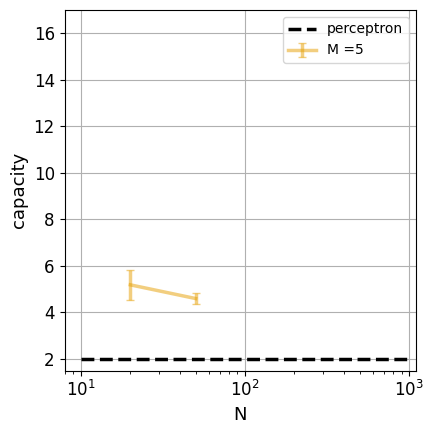

In [74]:
ax = plt.figure(figsize=(4.5, 4.5))
color = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
# plt.errorbar(capacity1[:, 0], capacity1[:, 2], yerr = capacity1[:, 3], capsize = 2, color = 'k', label = 'M = 5')
for i, M in enumerate(capacity):
    # if M!=10:
    #     continue
    if M == 15:
        plt.errorbar(
            capacity[M][:-1, 0],
            capacity[M][:-1, 2],
            yerr=capacity[M][:-1, 3],
            capsize=3,
            color=color[i],
            label="M =" + str(M),
            linewidth=2,
            alpha=0.75,
        )
        continue
    if M == 10:
        plt.errorbar(
            capacity[M][:-1, 0],
            capacity[M][:-1, 2],
            yerr=capacity[M][:-1, 3],
            capsize=3,
            color=color[i],
            label="M =" + str(M),
            linewidth=2,
            alpha=0.75,
        )
        continue

    #         continue
    # #     if M==3:
    # #         plt.errorbar(capacity[M][:5, 0], capacity[M][:5, 2], yerr =capacity[M][:5, 3], \
    # #                  capsize = 3, color =color[i] , label = 'M ='+str(M), linewidth = 2,alpha = .6)
    # #         continue
    x, y, yerr = capacity[M][:, 0], capacity[M][:, 2], capacity[M][:, 3]
    print(x, y, yerr)
    plt.errorbar(
        x[~np.isnan(y)],
        y[~np.isnan(y)],
        yerr=yerr[~np.isnan(y)],
        capsize=3,
        color=color[i],
        label="M =" + str(M),
        linewidth=2.5,
        alpha=0.5,
    )
# plt.errorbar(
#     capacityms[:, 0],
#     capacityms[:, 1],
#     yerr=capacityms[:, 2],
#     capsize=3,
#     color="r",
#     label="unlimited",
#     linewidth=3,
# )
plt.plot(
    np.logspace(1, 3, 5), np.ones((5,)) * 2, "k--", linewidth=2.5, label="perceptron"
)
plt.xscale("log")
# plt.yscale('log')
# plt.xticks([0 + i*100 for i in range(12)])
plt.grid()

plt.xlabel("N", fontsize=13)
plt.ylabel("capacity", fontsize=13)
plt.ylim([1.5, 17])
plt.xlim([-10, 1.1e3])
plt.legend(ncol=1, prop={"size": 10})
# plt.grid()

plt.tight_layout()

plt.savefig("capacity_two.pdf")

In [ ]:
capacity

: 

# plot activation histogram

In [123]:
from parallel_synapse_gradient import *


class args:
    def init(self):
        N = 0
        M = 0
        seed = 0
        P = 0


args.N, args.M, args.seed, args.P = 2000, 5, 0, 32000
allActv = []
# for args.seed in range(10):
model_params = {
    "N": args.N,  # input dimension
    "M": args.M,  # parallel synapse number
    "seed": args.seed,
    "device": torch.device("cpu"),
}
train_params = {
    "margin": 0.1,  # only applied when 'loss' is hinge
    "threslr": 1e-6,
    "adamlr": 0.003,
    "minAmpli": 1e-1,
    "Nepoch": 160000,
    "P": args.P,
    "maxRecord": 4000,
    "downSample": 100,
    "NthresPool": int(args.P / 2),
}
path = ""
folder = "./N_" + str(model_params["N"])
# folder = './monsyn4'
#
path += (
    "N_"
    + str(model_params["N"])
    + "_M_"
    + str(model_params["M"])
    + "_P_"
    + str(train_params["P"])
    + "_seed_"
    + str(model_params["seed"])
)

data_ = load_model(folder + "/" + path + "_data")
inputX, label = (
    data_[:, :-1].to(model_params["device"]),
    data_[:, -1].to(model_params["device"]),
)


model = ParallelSyn(model_params)


state_dict = torch.load(folder + "/" + path, map_location=model_params["device"])
model.load_state_dict(state_dict, strict=False)

actv = inputX.unsqueeze(2) - model.thres.unsqueeze(0)
actv = actv * model.slope.unsqueeze(0)
actv = torch.tanh(actv)
actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)
allActv.append(
    (actv.detach().numpy() - np.median(actv.detach().numpy(), axis=0)).ravel()
)

FileNotFoundError: [Errno 2] No such file or directory: './N_2000/N_2000_M_5_P_32000_seed_0_data'

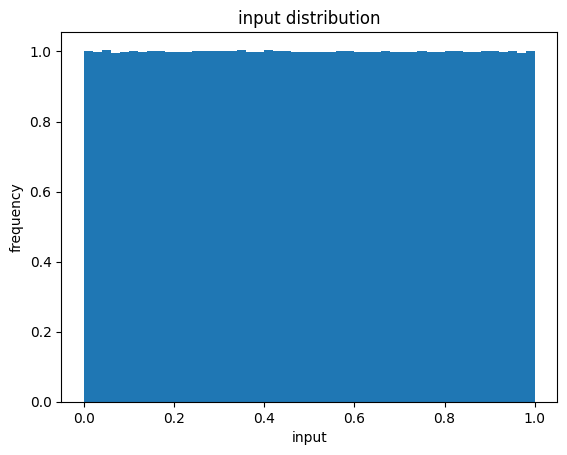

In [26]:
data_ = load_model(folder + "/" + path + "_data")
plt.hist(data_[:, :-1].ravel(), bins=50, density=True)
plt.xlabel("input")
plt.ylabel("frequency")
plt.title("input distribution")
plt.show()


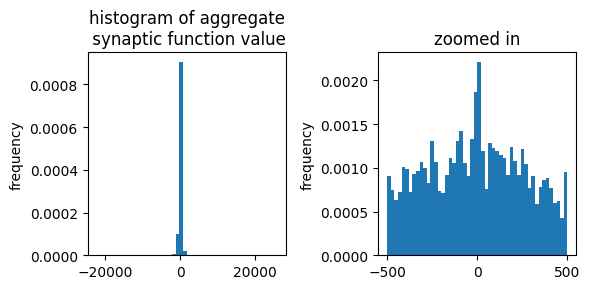

In [27]:
allActvArray = np.array(allActv)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(np.array(allActv).ravel(), bins=50, density=True)
plt.title("histogram of aggregate\n synaptic function value")
plt.ylabel("frequency")
plt.subplot(1, 2, 2)
allActvArray[np.abs(allActvArray) < 0.05] = np.nan
allActvArray[np.abs(allActvArray) > 500] = np.nan

plt.hist(allActvArray.ravel(), bins=50, density=True)
plt.title("zoomed in")
plt.ylabel("frequency")
plt.tight_layout()
# plt.savefig('totalactv.pdf')
plt.show()

In [28]:
def plot_activation(model, n, file):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]

    nX = 100
    """
    plot the staircase functions
    """
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )

    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()

    #     for i in range(n):
    #         actv[:, i] = actv[:, i] - np.median(actv[:, i]) + np.random.rand()
    x = x[:, 0]
    x = x.numpy()
    #     plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams.update({"font.size": 12})
    plt.figure(figsize=(4.5, 4.5))
    #     plt.subplot(1,2,1)
    #     plt.plot(x, actv)
    #     plt.xlabel('x')
    #     plt.ylabel('activation functions')
    #     if data['loss'][-1] == 0:
    #         plt.title('nDimension'+str(N) +', nSynapse '+str(M)+', nSample '+str(P)+'\n successfully classify all points')
    #     else:
    #         plt.title('nDimension'+str(N) +', nSynapse '+str(M)+', nSample '+str(P)+ '\n failed to classify all points')
    #     plt.title()
    #     plt.subplot(1,2,2)
    plt.plot(x, actv[:, :n], linestyle="-", alpha=0.8)
    # plt.xlim([-0.1, 1.1])
    #     plt.ylim([0,.6])
    plt.xlabel("input")
    plt.ylabel("arbitrary unit")
    plt.title("aggregate synaptic function")
    plt.tight_layout()
    plt.savefig("activation" + file + ".pdf")
    plt.show()

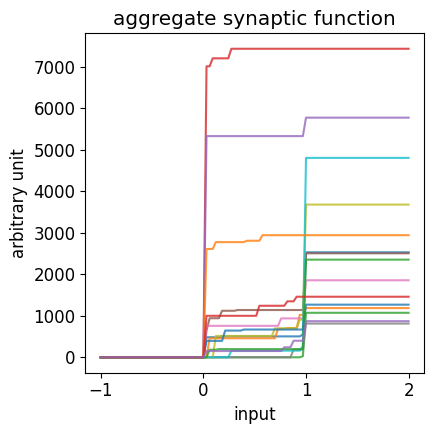

In [29]:
plot_activation(model, 15, "")


In [30]:
def plot_synaptic_amplitude(model):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach()
    thres = model.thres.detach()
    plt.figure(figsize=(4.5, 4.5))
    plt.hist(ampli.ravel(), bins=20, label="all")
    plt.hist(
        ampli[np.abs(thres - 0.5) > 0.45].ravel(),
        bins=20,
        alpha=0.9,
        label="thres. close to 0/1 within 0.05",
    )
    plt.hist(
        ampli[np.abs(thres - 0.5) > 0.49].ravel(),
        bins=20,
        alpha=0.8,
        label="thres. close to 0/1 within 0.01",
    )
    plt.legend()
    plt.show()

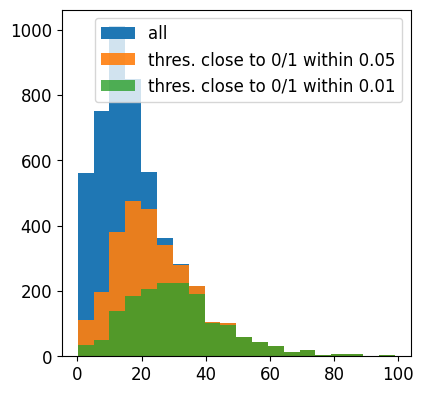

In [31]:
plot_synaptic_amplitude(model)

In [32]:
def thres_ampli(model):
    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9, 3.0), dpi=200)
    plt.subplot(1, 3, 1)
    #     y, bins = np.histogram(ampli.ravel(), bins = 50)
    #     plt.bar(bins[1:], y/y.sum())
    plt.hist(ampli.ravel(), bins=100)
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    plt.title("amplitude histogram")
    plt.subplot(1, 3, 2)
    plt.hist(thres.ravel(), bins=50)
    # y, bins = np.histogram(thres.ravel(), bins = 50)
    # plt.bar(bins[1:], y/y.sum())
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
    plt.title("threshold histogram")

    plt.subplot(1, 3, 3)

    plt.errorbar(thresBin[1:], allAmpli[:, 0], yerr=allAmpli[:, 1])
    plt.xlabel("Threshold")
    plt.ylabel("Amplitude ")
    plt.title("amplitude vs threshold")
    plt.tight_layout()
    plt.savefig("ampli_thres1.pdf")
    plt.show()

    plt.figure(figsize=(3.0, 3.0), dpi=200)
    plt.hist(ampli.ravel(), bins=np.logspace(-1, 4.5, 100))
    plt.xscale("log")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("ampli_log_scale.pdf")
    # plt.title("amplitude histogram")
    plt.show()

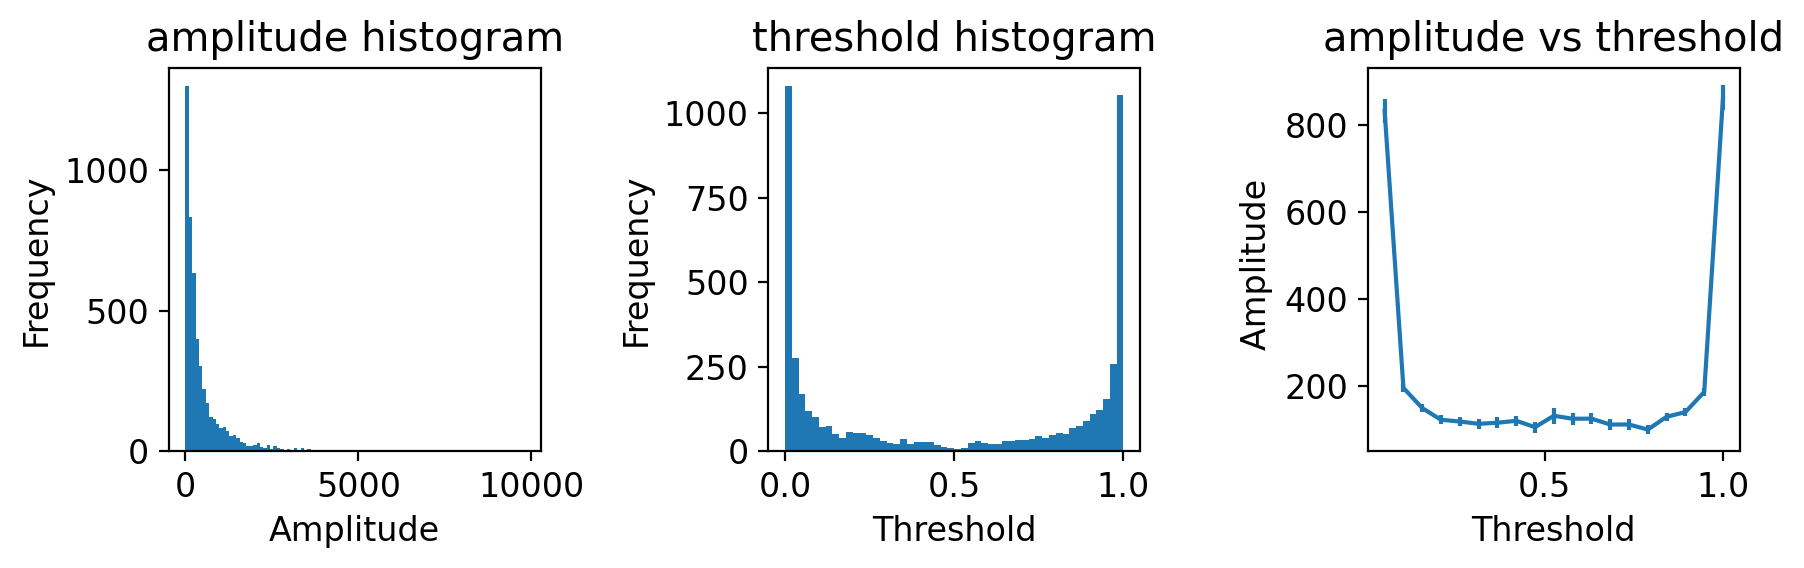

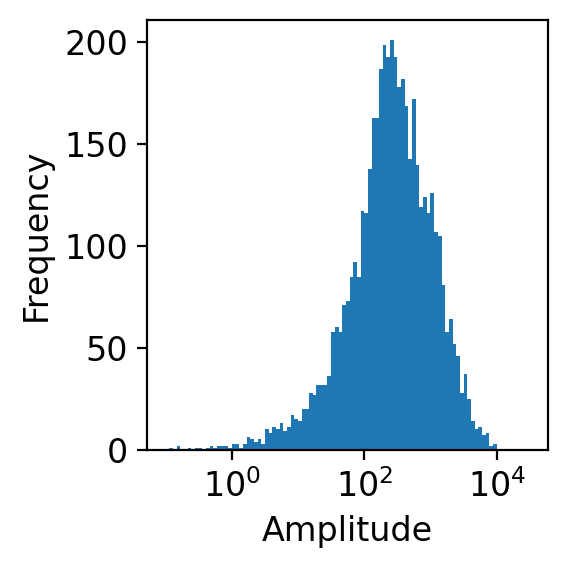

In [9]:
thres_ampli(model)

In [99]:
def ampli_hist(model):
    """
    plot the amplitude histogram of the synaptic function

    method 0:
        plot the histogram of the nonzero a**2
    method 1:
        local variation of the amplitude
    method 2:
        starting from zero, get slopes

    """

    nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
    ampli = model.ampli.detach() ** 2

    # method 0
    thres = model.thres.detach()
    nBin = 20
    thresBin = np.linspace(thres.min(), thres.max(), nBin)
    allAmpli = []
    for i in range(1, nBin):
        ampli_ = ampli[(thres > thresBin[i - 1]) * (thres <= thresBin[i])]
        allAmpli.append([ampli_.mean(), ampli_.std() / np.sqrt(len(ampli_))])
    allAmpli = np.array(allAmpli)
    plt.figure(figsize=(9.0, 6.0), dpi=300)
    plt.subplot(2, 3, 1)
    plt.hist(ampli[ampli > 1e-3], bins=np.logspace(-2, 6, 100))

    plt.xscale("log")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    # plt.title("a_{ij}^2")
    # plt.tight_layout()
    # plt.savefig("a_squared_log_scale.pdf")
    # plt.title("amplitude histogram")

    # method 1, local variation of the amplitude
    nX = 100
    thresMin = model.thres.min().item()
    thresMax = model.thres.max().item()
    x = torch.tile(
        torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim)
    )
    actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
    actv = actv * model.slope.unsqueeze(0)
    actv = (torch.tanh(actv) + 1) / 2
    actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

    actv = actv.detach().numpy()
    x = x[:, 0]
    x = x.numpy()
    actv_local_slope = np.diff(actv, axis=0).T / np.diff(x).ravel()
    actv_local_slope = actv_local_slope[
        ~np.isnan(actv_local_slope) & (actv_local_slope > 0)
    ]
    plt.subplot(2, 3, 2)
    plt.hist(actv_local_slope, bins=np.logspace(-2, 6, 100))
    plt.xscale("log")
    plt.xlabel("Local synaptic weights")
    plt.ylabel("Frequency")

    actv_global_slope = (actv[1:, :] - actv[0, :]).T / (x[1:] - x[0]).ravel()
    actv_global_slope = actv_global_slope[
        ~np.isnan(actv_global_slope) & (actv_global_slope > 0)
    ]

    plt.subplot(2, 3, 3)
    plt.hist(actv_global_slope, bins=np.logspace(-2, 6, 100))

    # Kolmogorov-Smirnov Test
    # Calculate mean and std for each distribution
    global_mean = np.mean(actv_global_slope)
    global_std = np.std(actv_global_slope)

    # Create gaussian fit using mean and std
    x_fit = np.logspace(
        np.log10(actv_global_slope.min()), np.log10(actv_global_slope.max()), 100
    )
    gaussian = (1 / (global_std * np.sqrt(2 * np.pi))) * np.exp(
        -((x_fit - global_mean) ** 2) / (2 * global_std**2)
    )

    # Plot the fitted gaussian on same axes
    plt.plot(
        x_fit,
        gaussian * len(actv_global_slope) * (x_fit[1] - x_fit[0]),
        "r-",
        label="Gaussian fit",
    )
    plt.legend()
    plt.xscale("log")
    plt.xlabel("Global synaptic weights")
    plt.ylabel("Frequency")

    # plot cumulative distribution
    plt.subplot(2, 3, 4)
    plt.hist(
        ampli[ampli > 1e-3],
        bins=np.logspace(-3, 5, 100),
        density=True,
        cumulative=True,
        histtype="step",
    )
    plt.xlim(ampli.min(), ampli.max())
    plt.xscale("log")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")
    plt.title("cumulative distribution")

    plt.subplot(2, 3, 5)
    plt.hist(
        actv_local_slope,
        bins=np.logspace(-3, 6, 100),
        density=True,
        cumulative=True,
        histtype="step",
    )
    plt.xlim(actv_local_slope.min(), actv_local_slope.max())
    plt.xscale("log")
    plt.xlabel("Local synaptic weights")
    plt.ylabel("Frequency")
    plt.title("cumulative distribution")

    plt.subplot(2, 3, 6)
    plt.hist(
        actv_global_slope,
        bins=np.logspace(-3, 5, 100),
        density=True,
        cumulative=True,
        histtype="step",
    )
    plt.xlim(actv_global_slope.min(), actv_global_slope.max())
    plt.xscale("log")
    plt.xlabel("Global synaptic weights")
    plt.ylabel("Frequency")
    plt.title("cumulative distribution")

    plt.tight_layout()
    plt.savefig("ampli_hist.pdf")
    plt.show()


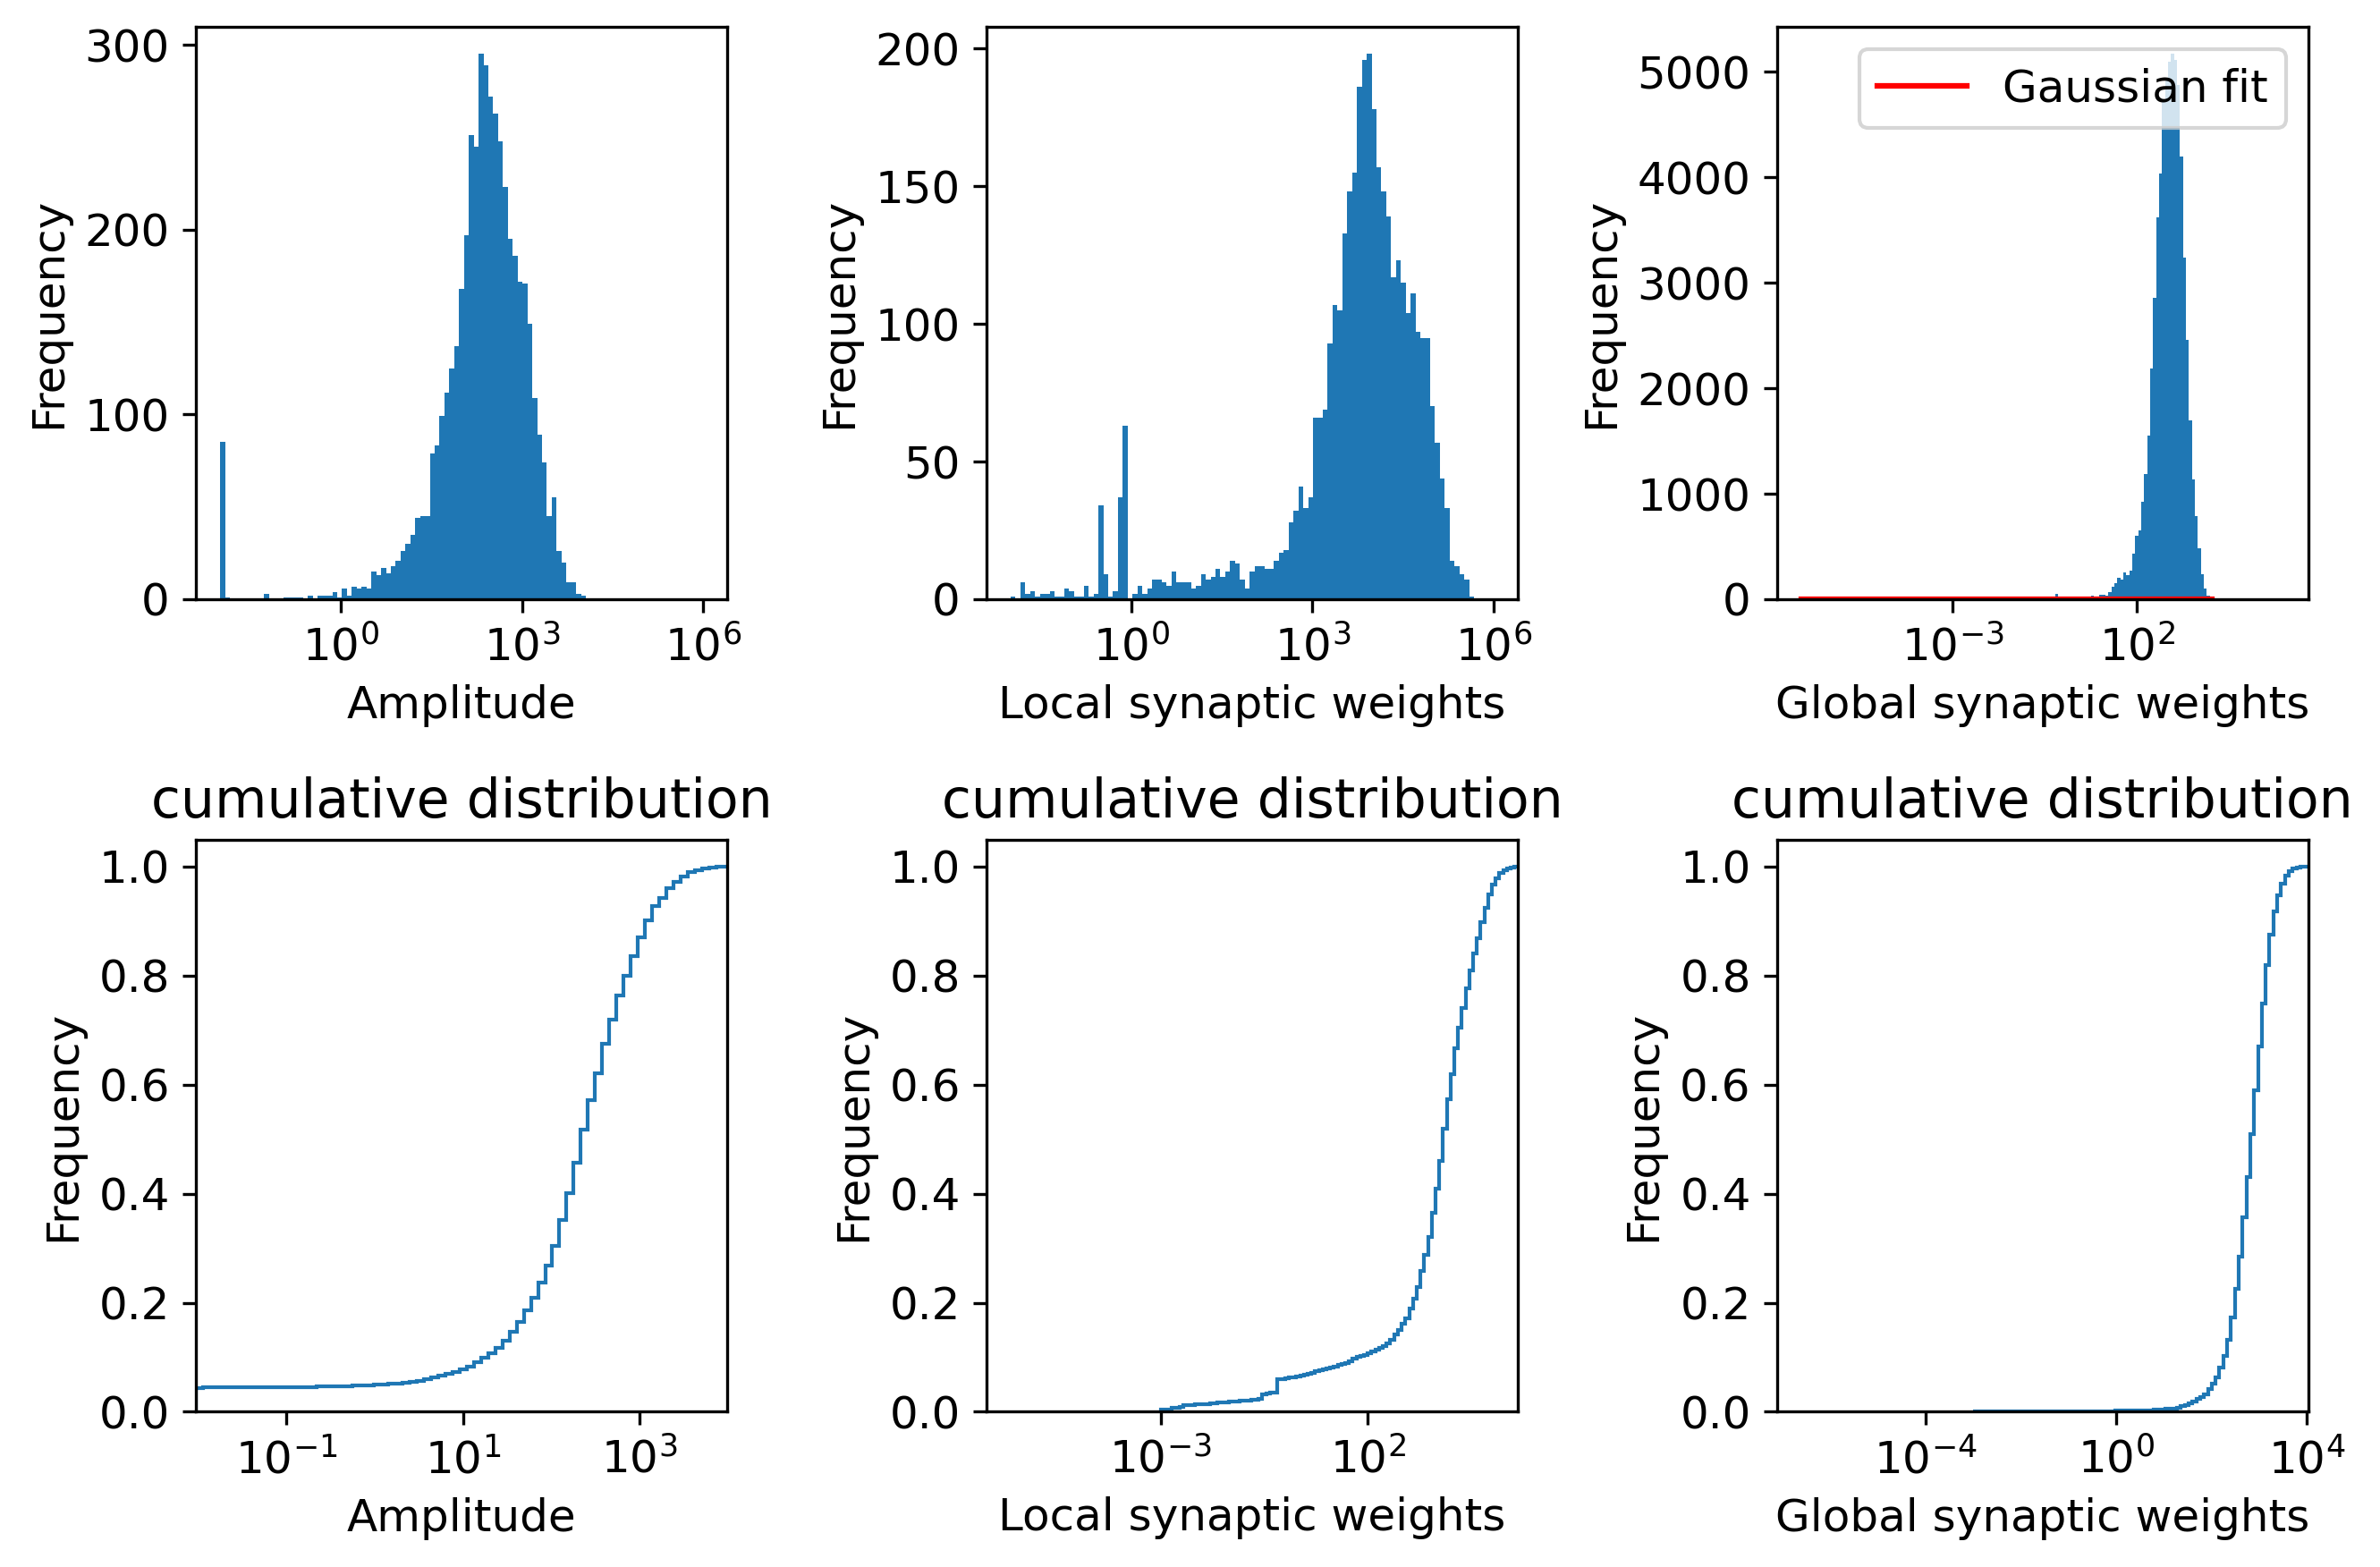

In [100]:
ampli_hist(model)

In [104]:
# method 1, local variation of the amplitude

nDim, nSyn = model.ampli.shape[0], model.ampli.shape[1]
nX = 100
thresMin = model.thres.min().item()
thresMax = model.thres.max().item()
x = torch.tile(torch.linspace(thresMin - 1, thresMax + 1, nX).unsqueeze(1), (1, nDim))
actv = x.unsqueeze(2) - model.thres.unsqueeze(0)
actv = actv * model.slope.unsqueeze(0)
actv = (torch.tanh(actv) + 1) / 2
actv = (model.ampli.pow(2).unsqueeze(0) * actv).sum(axis=-1)

actv = actv.detach().numpy()
x = x[:, 0]
x = x.numpy()


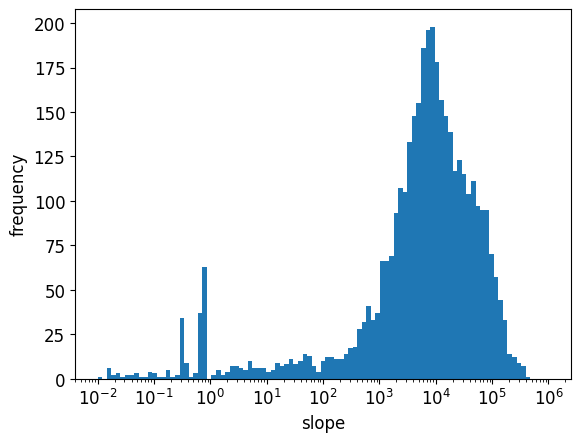

(1000, 99)


In [116]:
actv_local_slope = np.diff(actv, axis=0).T / np.diff(x).ravel()
actv_local_slope = actv_local_slope[
    ~np.isnan(actv_local_slope) & (actv_local_slope > 0)
]
plt.hist(actv_local_slope, bins=np.logspace(-2, 6, 100))
plt.xscale("log")
plt.xlabel("slope")
plt.ylabel("frequency")
plt.show()
actv_global_slope = (actv[1:, :] - actv[0, :]).T / np.diff(x).ravel()
print(actv_global_slope.shape)
actv_global_slope = actv_global_slope[
    ~np.isnan(actv_global_slope) & (actv_global_slope > 0)
]
# actv_global_slope.shape


In [124]:
N = 2000
P = 32000
seed = 0
actv = []
for i in range(1):
    with open(
        "./monsyn4/N" + str(N) + "P" + str(P) + "trial" + str(i) + "func.txt", "r"
    ) as f:
        line = f.readline()
        while line:
            line = line.replace(" \n", "")
            actv.append([float(a) for a in line.split(" ")])
            line = f.readline()

actv = np.array(actv)

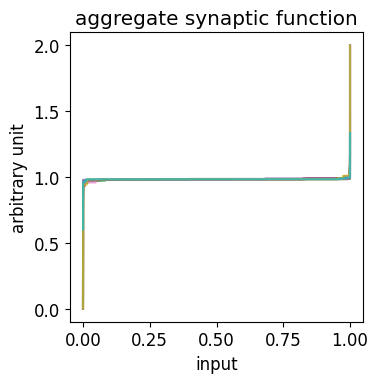

In [102]:
nShow = 10
plt.figure(figsize=(4, 4.0))
plt.rcParams.update({"font.size": 12})
plt.plot(np.linspace(0, 1, P), actv[:nShow, :].T, alpha=0.7)
plt.xlabel("input")
plt.ylabel("arbitrary unit")
plt.title("aggregate synaptic function")
plt.tight_layout()
# plt.savefig("activation" + "monsyn.pdf")
plt.show()
# TODO: curves start from 0


(2000, 31999)


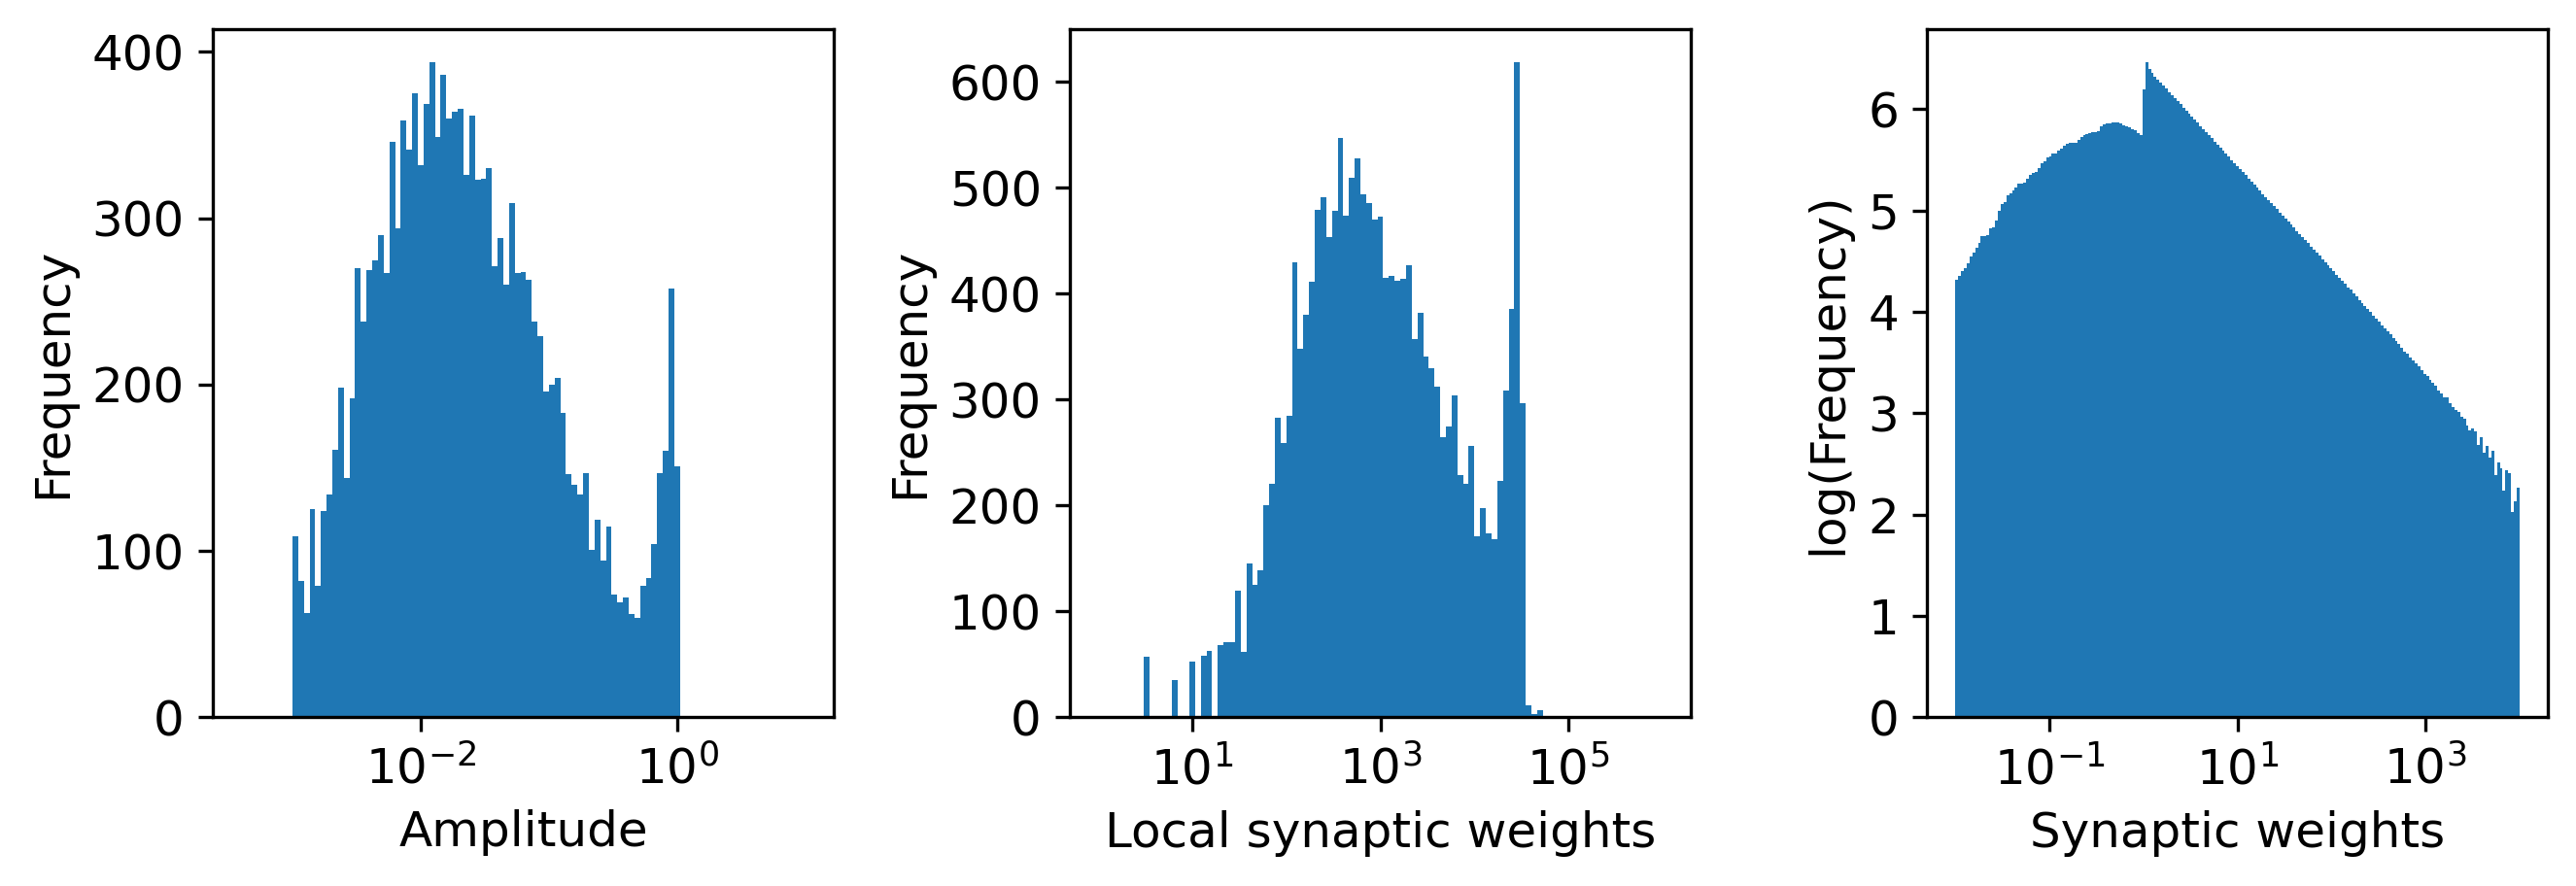

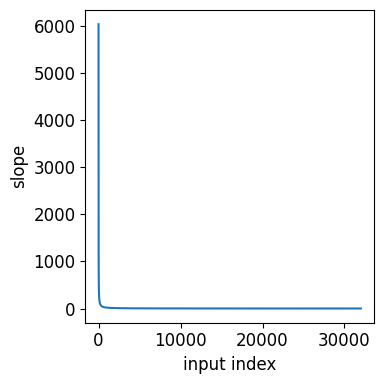

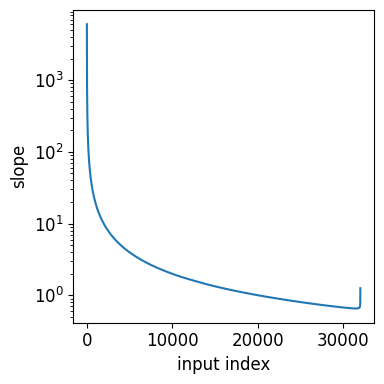

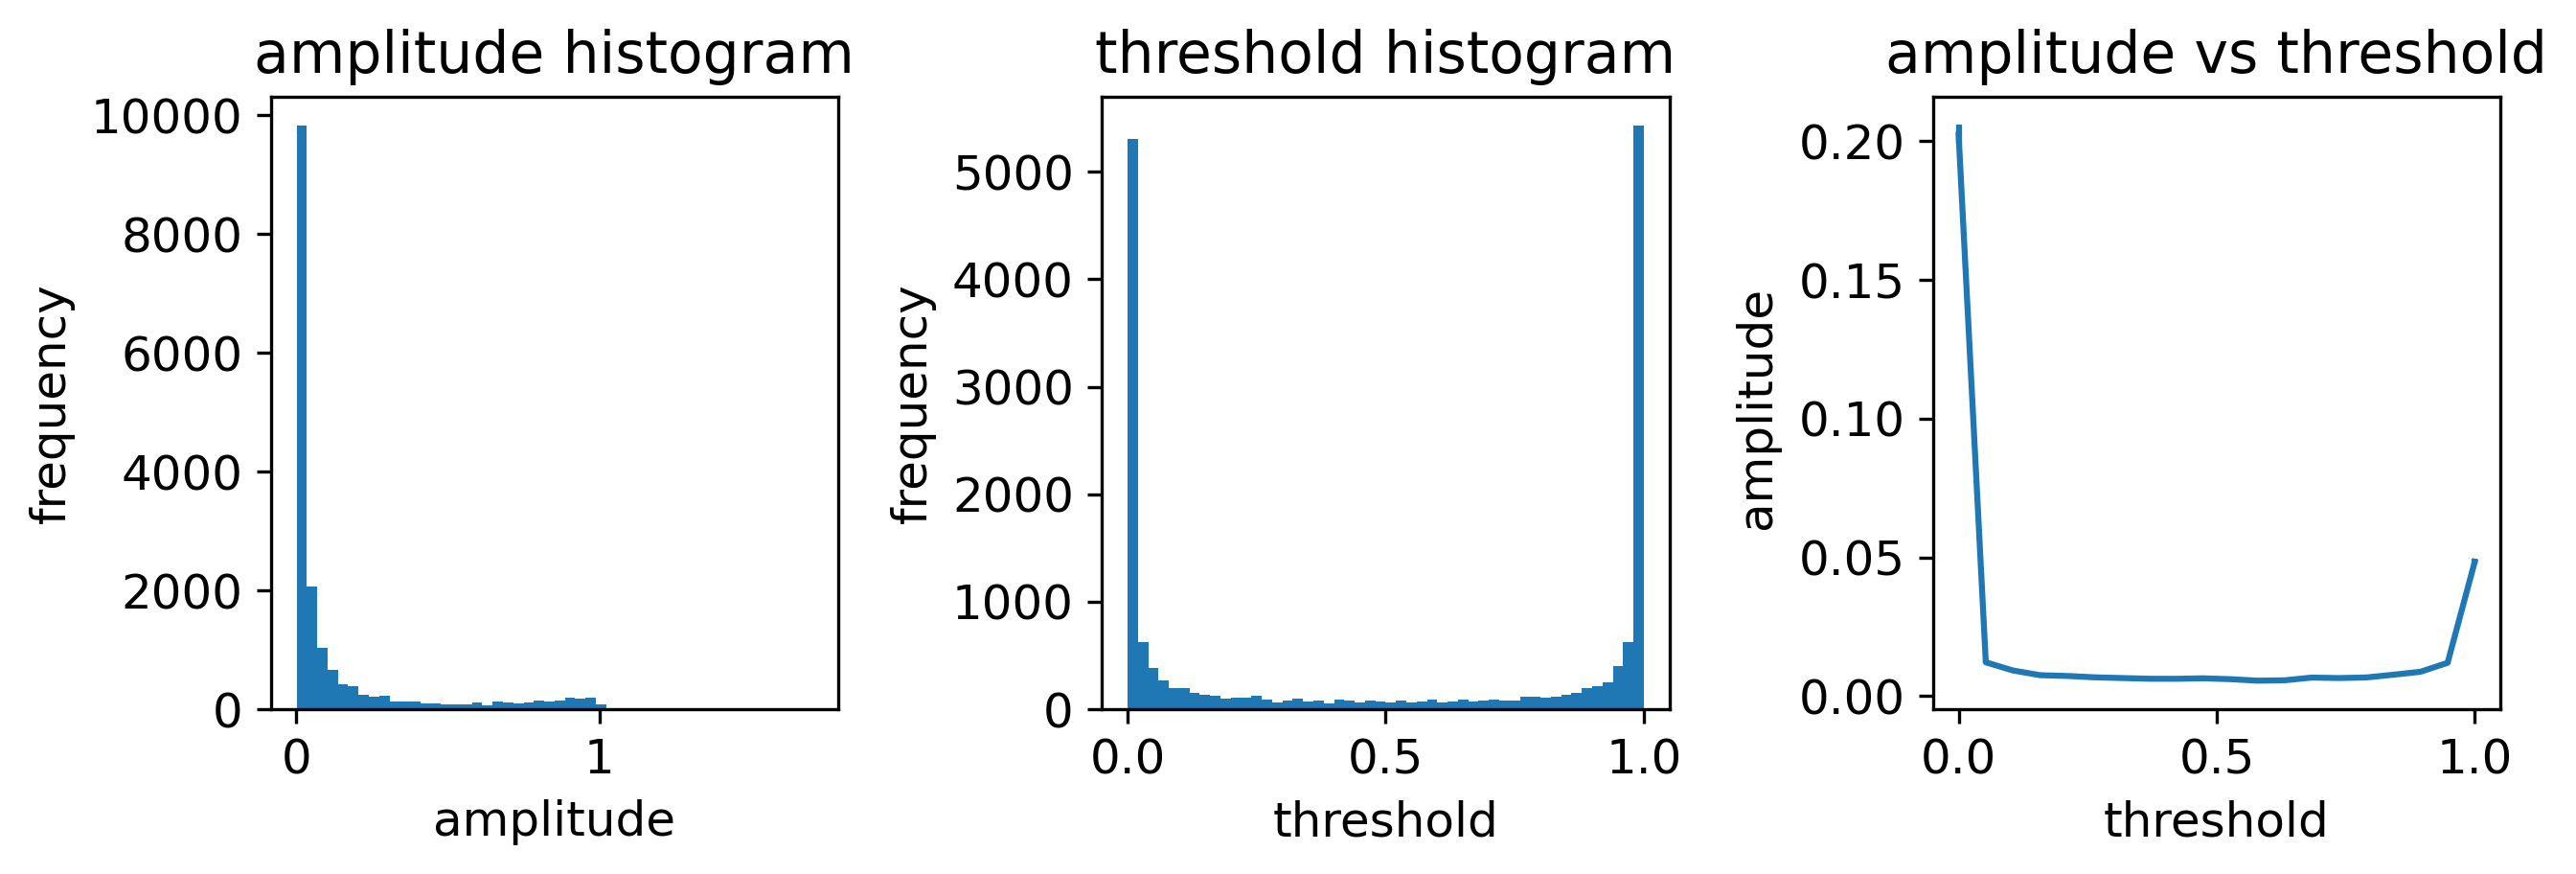

In [134]:
from itertools import chain

amp = np.diff(actv, axis=1)
nBin = 20
ampli = []
N, P = amp.shape
step = int(P / nBin)
for i in range(nBin):
    start = i * step
    end = (i + 1) * step
    tmp = amp[:, start:end]
    ampli.append(tmp[tmp > 0.001])
thres = [np.where(amp[i, :] > 0)[0] / amp.shape[1] for i in range(amp.shape[0])]
x = np.linspace(0, 1, P + 1)
actv_local_slope = np.diff(actv, axis=1) / np.diff(x)
actv_local_slope = actv_local_slope[
    ~np.isnan(actv_local_slope) & (actv_local_slope > 1e-4)
]

actv_global_slope = (actv[:, 1:] - actv[:, 0].reshape(-1, 1)) / (x[1:] - x[0]).ravel()
print(actv_global_slope.shape)
actv_global_slope = actv_global_slope[
    ~np.isnan(actv_global_slope) & (actv_global_slope > 1e-4)
]
# actv_global_slope.shape


plt.figure(figsize=(9, 3.2), dpi=300)
plt.subplot(1, 3, 1)
ampli_array = np.array(list(chain(*ampli)))
plt.hist(ampli_array[ampli_array > 1e-4], bins=np.logspace(-3.4, 1, 100))
plt.xscale("log")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
plt.subplot(1, 3, 2)
plt.hist(actv_local_slope, bins=np.logspace(0, 6, 100))
plt.xscale("log")
plt.xlabel("Local synaptic weights")
plt.ylabel("Frequency")
plt.subplot(1, 3, 3)
freq, bins = np.histogram(actv_global_slope, bins=np.logspace(-2, 4, 200))
bin_centers = (bins[:-1] + bins[1:]) / 2
# freq[freq < 1e3] = 0  # Zero out frequencies below 10^3

# plt.yscale('log')
plt.bar(bin_centers, np.log10(freq), width=np.diff(bins), align="center", alpha=1)
plt.xscale("log")
plt.xlabel("Synaptic weights")
plt.ylabel("log(Frequency)")
plt.tight_layout()

plt.savefig("ampli_hist_slope_monsyn_solved.pdf")
plt.show()

plt.figure(figsize=(4, 4.0))
actv_global_slope = (actv[:, 1:] - actv[:, 0].reshape(-1, 1)) / (x[1:] - x[0]).ravel()

plt.plot(np.nanmean(actv_global_slope, axis=0))
plt.xlabel("input index")
plt.ylabel("slope")
plt.tight_layout()
plt.savefig("slope_monsyn_solved1.pdf")
plt.show()

idx = 1
plt.figure(figsize=(4, 4.0))
actv_global_slope = (actv[:, idx:] - actv[:, 0].reshape(-1, 1)) / (
    x[idx:] - x[0]
).ravel()

plt.plot(np.nanmean(actv_global_slope, axis=0))
plt.yscale("log")
plt.xlabel("input index")
plt.ylabel("slope")
plt.tight_layout()
plt.savefig("slope_monsyn_solved1.pdf")
plt.show()

plt.figure(figsize=(9, 3.2), dpi=300)

plt.subplot(1, 3, 1)
plt.hist(amp[amp > 0], bins=50)
plt.xlabel("amplitude")
plt.ylabel("frequency")
plt.title("amplitude histogram")
plt.subplot(1, 3, 2)
plt.hist(np.concatenate(thres, axis=0), bins=50)
plt.xlabel("threshold")

plt.ylabel("frequency")
plt.title("threshold histogram")
plt.subplot(1, 3, 3)
plt.errorbar(
    np.linspace(0, 1, nBin),
    [amp.mean() for amp in ampli],
    yerr=[amp.std() / np.sqrt(len(amp)) for amp in ampli],
)

plt.xlabel("threshold")
plt.ylabel("amplitude ")
plt.title("amplitude vs threshold")
plt.tight_layout()
plt.savefig("ampli_thres_monsyn_solved.pdf")
plt.show()

In [92]:
actv_local_slope = np.diff(actv, axis=1) / np.diff(x)
(actv_global_slope > 1e-4).sum()

15766799

Text(0, 0.5, 'Frequency')

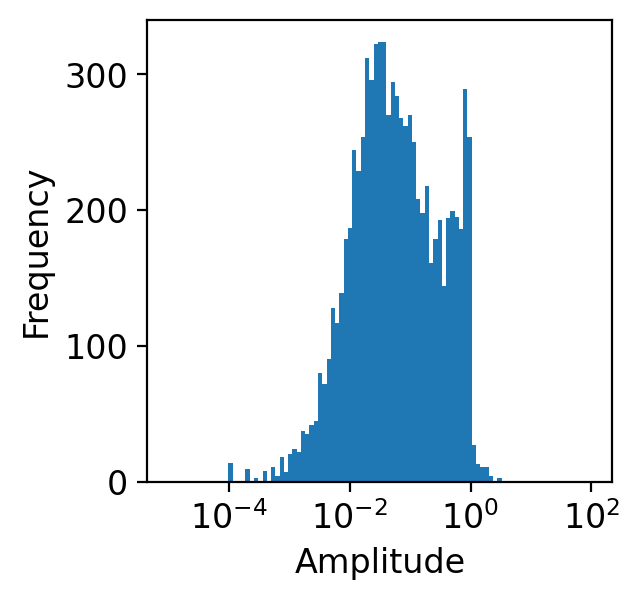

In [71]:
plt.figure(figsize=(3, 3.0), dpi=200)
plt.hist(amp[amp > 0], bins=np.logspace(-5, 2, 100))
plt.xscale("log")
plt.xlabel("Amplitude")
plt.ylabel("Frequency")
# plt.title("amplitude histogram")

In [ ]:
actvArray = actv

plt.figure(figsize=(3, 3))
plt.hist(np.array(actv).ravel(), bins=150, density=True)
plt.title("histogram of aggregate\n synaptic function value")
plt.ylabel("frequency")

plt.tight_layout()
plt.savefig("totalactvmonsyn.pdf")
plt.show()

: 

In [ ]:
# load N=200 capacity